### Import libraries and data

Import the libaries

In [ ]:
import pickle
import pandas as pd
import numpy as np

Import the data and the models

In [2]:
final_rf = pickle.load(open('final_rf_model.pkl', 'rb'))
X_train = pd.read_pickle('X_train.pkl')
y_train = np.load('y_train.npy', allow_pickle=True)

### Tree visualization

In this section we can observe the decision rules from a single tree within our random forest model:

- We can view the decision rules with a max depth of 2, as with a depth of 3 we already have problems visualizing it

- We can view the leaf nodes of the tree and the decisions made to get to it

- We will observe common root nodes and class distribution in leaves

- We will analyze the most common paths for each class

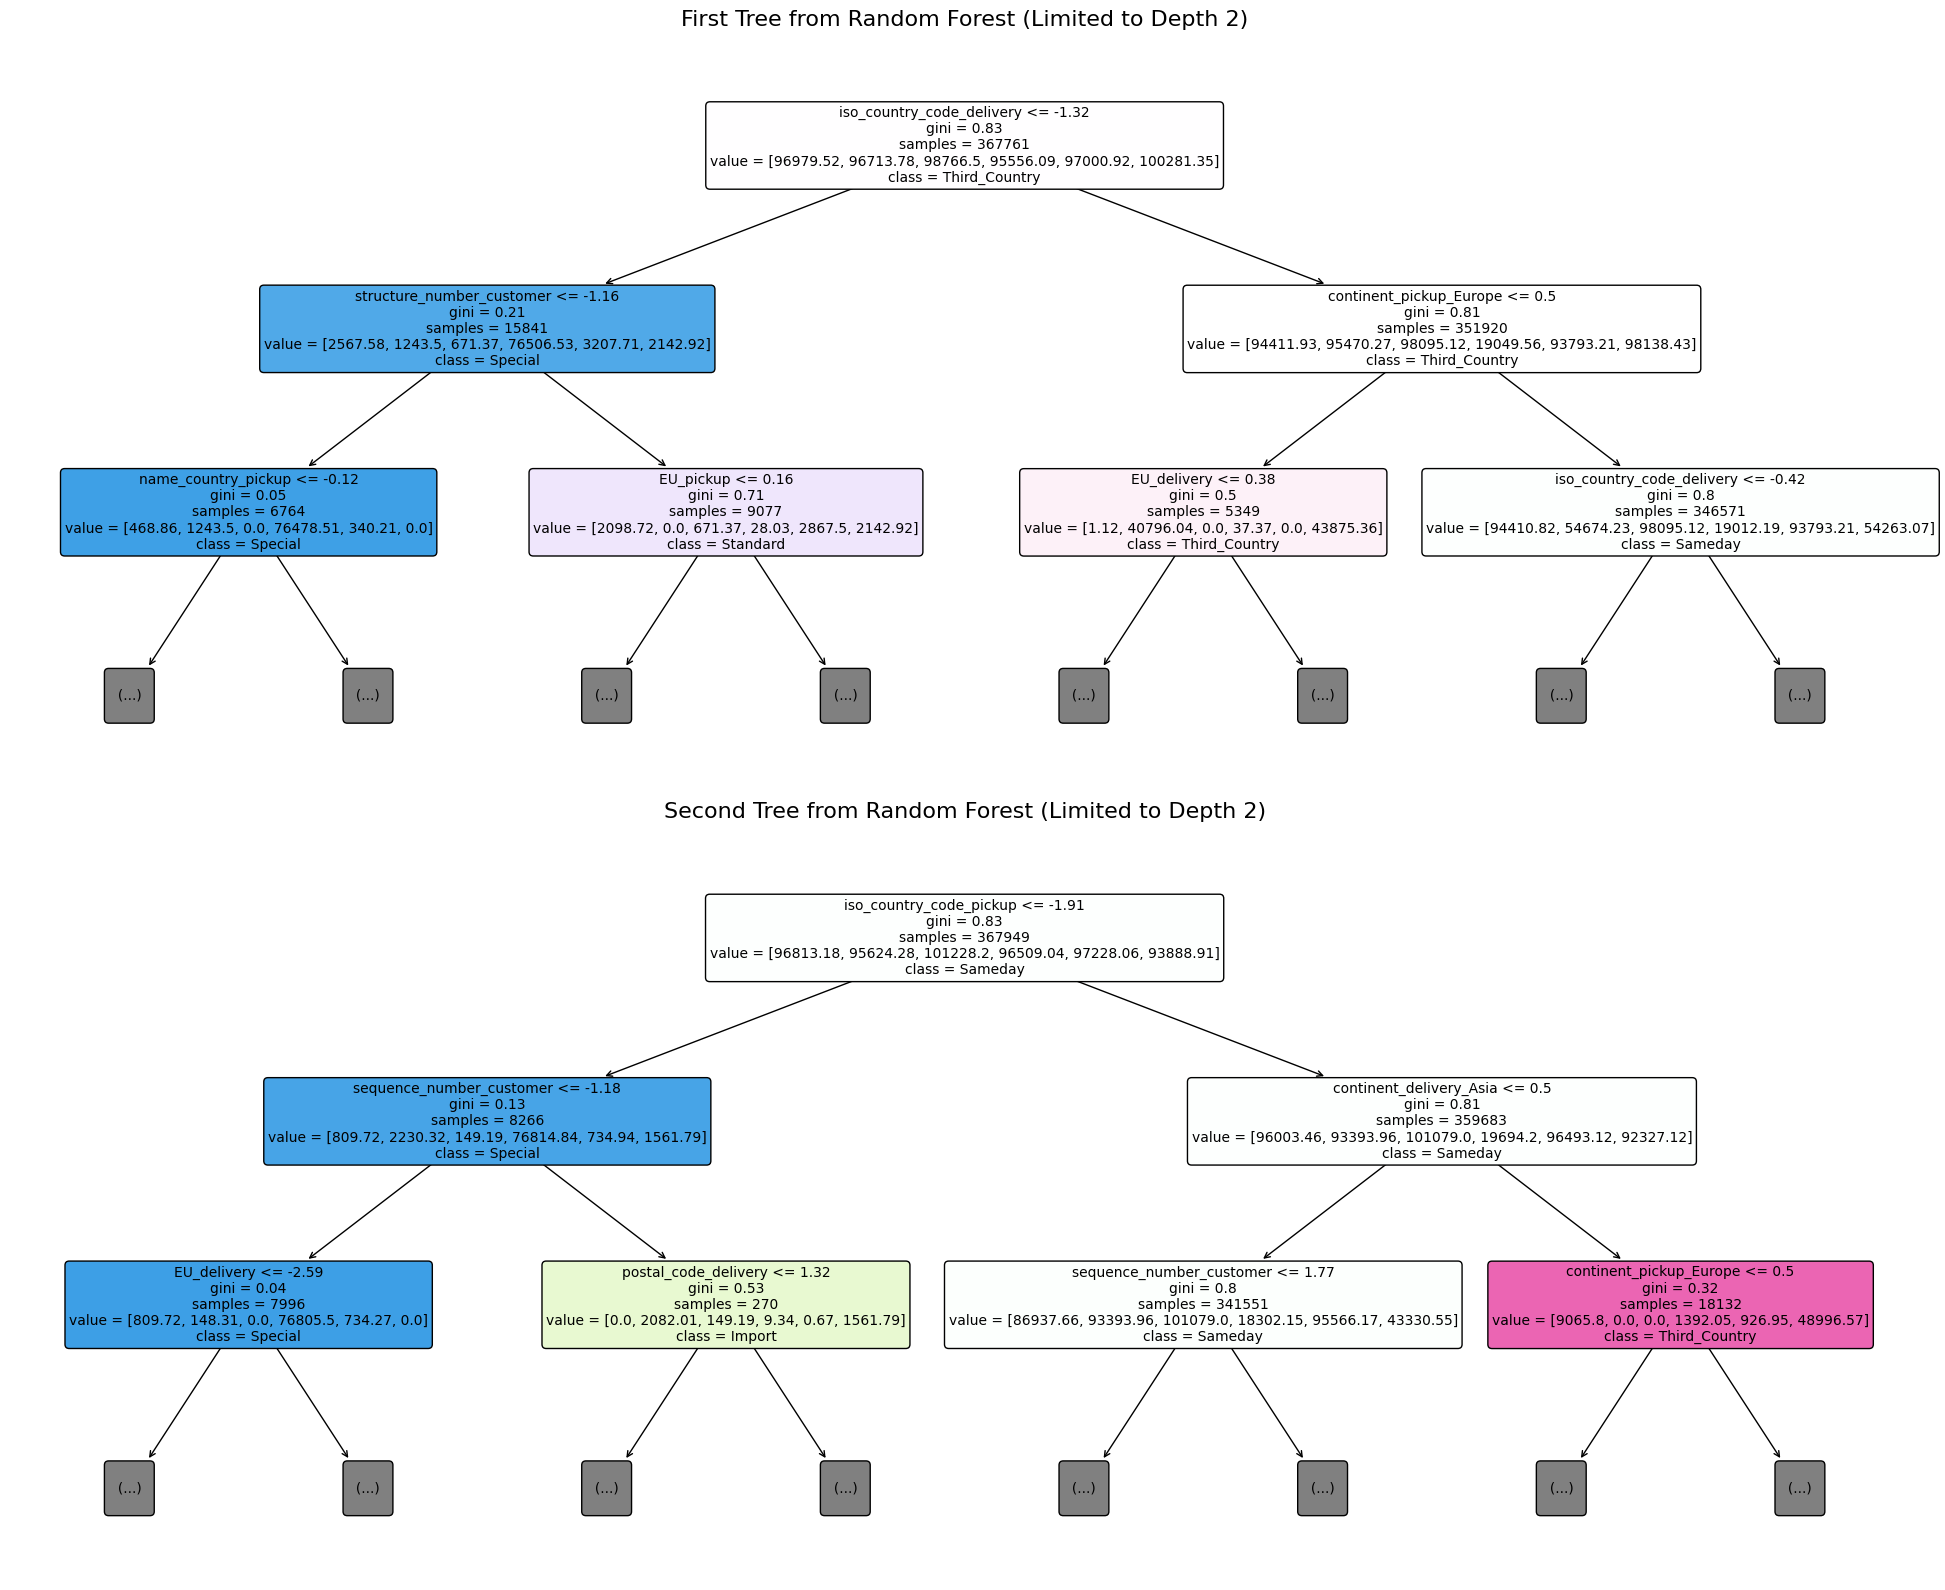


Decision Rules for First Tree:
--------------------------------------------------
Depth 1
If iso_country_code_delivery <= -1.32:
Depth 2
If structure_number_customer <= -1.16:
If structure_number_customer > -1.16:
------------------------------
If iso_country_code_delivery > -1.32:
Depth 2
If continent_pickup_Europe <= 0.50:
If continent_pickup_Europe > 0.50:
------------------------------
------------------------------

Decision Rules for Second Tree:
--------------------------------------------------
Depth 1
If iso_country_code_pickup <= -1.91:
Depth 2
If sequence_number_customer <= -1.18:
If sequence_number_customer > -1.18:
------------------------------
If iso_country_code_pickup > -1.91:
Depth 2
If continent_delivery_Asia <= 0.50:
If continent_delivery_Asia > 0.50:
------------------------------
------------------------------


In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Analyze two trees from the random forest
tree1 = final_rf.estimators_[0]  # First tree
tree2 = final_rf.estimators_[1]  # Second tree
tree1_ = tree1.tree_
tree2_ = tree2.tree_

# Visualize both tree structures
plt.figure(figsize=(20, 16))

# Plot first tree
plt.subplot(2, 1, 1)
plot_tree(tree1,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("First Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

# Plot second tree
plt.subplot(2, 1, 2)
plot_tree(tree2,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("Second Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Print decision rules for both trees
def print_rules(node, depth, path, tree_, X_train):
    if depth > 2:
        return

    if tree_.children_left[node] != tree_.children_right[node]:  # internal node
        name = X_train.columns[tree_.feature[node]]
        threshold_val = tree_.threshold[node]
        print("Depth", depth)
        print(f"If {name} <= {threshold_val:.2f}:")
        print_rules(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold_val:.2f}"], tree_, X_train)
        print(f"If {name} > {threshold_val:.2f}:")
        print_rules(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold_val:.2f}"], tree_, X_train)
        print("-" * 30)

print("\nDecision Rules for First Tree:")
print("-" * 50)
print_rules(0, 1, [], tree1_, X_train)

print("\nDecision Rules for Second Tree:")
print("-" * 50)
print_rules(0, 1, [], tree2_, X_train)


In the next cell, we are going to look at 5 sample nodes from each tree, from root to leaf node.

In [4]:
# Function to print leaf nodes for a specific tree
def print_leaves(node, path, tree_, X_train, final_rf, leaves_printed):
    if leaves_printed[0] >= 5:
        return

    if tree_.feature[node] == -2:  # leaf node
        predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
        n_samples = tree_.n_node_samples[node]
        print(f"\nLeaf Node {leaves_printed[0] + 1}:")
        print(f"Decision Path: {' AND '.join(path)}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Number of samples in leaf: {n_samples}")
        print("-" * 50)
        leaves_printed[0] += 1
        return

    name = X_train.columns[tree_.feature[node]]
    threshold = tree_.threshold[node]

    print_leaves(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)
    if leaves_printed[0] < 5:
        print_leaves(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)

# Print sample leaf nodes for both trees
print("\nSample of 5 Leaf Nodes from First Tree:")
print("=" * 50)
leaves_printed1 = [0]  # Using list to make it mutable
print_leaves(0, [], tree1_, X_train, final_rf, leaves_printed1)

print("\nSample of 5 Leaf Nodes from Second Tree:")
print("=" * 50)
leaves_printed2 = [0]  # Using list to make it mutable
print_leaves(0, [], tree2_, X_train, final_rf, leaves_printed2)


Sample of 5 Leaf Nodes from First Tree:

Leaf Node 1:
Decision Path: iso_country_code_delivery <= -1.32 AND structure_number_customer <= -1.16 AND name_country_pickup <= -0.12 AND city_pickup <= 0.68 AND structure_number_customer <= -1.16 AND structure_number_customer <= -1.17 AND postal_code_delivery <= 0.09 AND city_pickup <= -0.76
Predicted Class: Standard
Number of samples in leaf: 6
--------------------------------------------------

Leaf Node 2:
Decision Path: iso_country_code_delivery <= -1.32 AND structure_number_customer <= -1.16 AND name_country_pickup <= -0.12 AND city_pickup <= 0.68 AND structure_number_customer <= -1.16 AND structure_number_customer <= -1.17 AND postal_code_delivery <= 0.09 AND city_pickup > -0.76 AND sequence_number_customer <= -1.26 AND structure_number_customer <= -1.32
Predicted Class: Express
Number of samples in leaf: 7
--------------------------------------------------

Leaf Node 3:
Decision Path: iso_country_code_delivery <= -1.32 AND structure_nu

By analyzing them, we have the following insights:
Geographic Patterns:
- ISO country codes as root-level decision factors (both pickup/delivery)
- Continental regions (Europe/Asia) serve as major service classifiers
- Pickup/delivery location combinations drive routing paths
- City and postal code patterns create granular distinctions  
- Non-European pickup locations trigger distinct service paths

Customer Characteristics:  
- Structure and sequence numbers are critical decision inputs
- Lower structure/sequence numbers (-1.16 to -1.32) correlate with Standard services
- Higher structure numbers typically route to Express services
- Organizational relationships (sequence/structure relationships) guide service selection
- Complex structural attribute combinations refine final service determination

Shipment & Location Rules:
- Document vs Parcel classification impacts service paths
- EU delivery status acts as key service classifier
- City characteristics combine with structural factors
- Postal code thresholds refine geographic service zones
- Multi-layered location attributes create complex decision paths
- Deep location-based nesting reflects regulatory requirements

Service Selection Patterns:
- Express services require combinations of:
  - Specific customer structural attributes 
  - Geographic location pair matches
  - Shipment type classifications
 
- Standard services align with:
  - Lower structure/sequence numbers
  - Defined geographic zones
  - Particular customer segments

- Third-country routing depends on:
  - Continental boundary checks
  - ISO country code validation  
  - EU status verification

In the following cell, we are going to analyze the most common root features and the class distribution in leaves.

In [5]:
n_trees = 100

# Initialize counters for pattern analysis
feature_at_root = {}    # Features used at root node
common_paths = {}       # Common decision paths leading to each class
class_distributions = {} # Distribution of predicted classes per tree
avg_depth = 0          # Average tree depth

# Analyze patterns across specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Count root feature
    root_feature = X_train.columns[tree_.feature[0]]
    feature_at_root[root_feature] = feature_at_root.get(root_feature, 0) + 1

    # Analyze class distribution in leaves
    leaves_mask = tree_.feature == -2
    leaf_classes = [final_rf.classes_[np.argmax(tree_.value[i][0])]
                   for i in range(len(tree_.feature)) if leaves_mask[i]]

    for class_name in leaf_classes:
        class_distributions[class_name] = class_distributions.get(class_name, 0) + 1

    # Calculate tree depth
    avg_depth += tree_.max_depth

avg_depth /= n_trees

# Print analysis results
print(f"\nAnalysis of {n_trees} trees:")
print("\nMost Common Root Features:")
for feature, count in sorted(feature_at_root.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {count} trees ({count/n_trees*100:.1f}%)")

print("\nClass Distribution in Leaves:")
total_leaves = sum(class_distributions.values())
for class_name, count in sorted(class_distributions.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name}: {count} leaves ({count/total_leaves*100:.1f}%)")

print(f"\nAverage Tree Depth: {avg_depth:.1f}")


Analysis of 100 trees:

Most Common Root Features:
name_country_pickup: 34 trees (34.0%)
iso_country_code_pickup: 21 trees (21.0%)
name_country_delivery: 13 trees (13.0%)
iso_country_code_delivery: 12 trees (12.0%)
structure_number_customer: 7 trees (7.0%)
continent_delivery_Asia: 4 trees (4.0%)
continent_pickup_Europe: 3 trees (3.0%)
sequence_number_customer: 3 trees (3.0%)
EU_pickup: 2 trees (2.0%)
postal_code_pickup: 1 trees (1.0%)

Class Distribution in Leaves:
Standard: 1375604 leaves (50.4%)
Express: 1268187 leaves (46.5%)
Special: 36964 leaves (1.4%)
Import: 20366 leaves (0.7%)
Sameday: 16266 leaves (0.6%)
Third_Country: 9297 leaves (0.3%)

Average Tree Depth: 54.4


By analyzing them, we have the following insights:

Primary Features
* Location dominates as decision factor, with 80% of root splits based on geographic features:
  * Pickup-related features account for 55% of root nodes (country names 34%, ISO codes 21%)
  * Delivery-related features drive 25% of initial decisions (country names 13%, ISO codes 12%)
  * Continental features present in higher proportion than before (7% combined)

Secondary Features  
* Customer characteristics influence 10% of initial splits:
  * Structure number: 7%
  * Sequence number: 3%
* Postal codes appear in just 1% of root nodes

Main Services
* Standard service represents majority of classifications (50.4%)
* Express service follows closely at 46.5%
* Combined, these two services account for 96.9% of all decisions

Specialized Services
* Special shipments: 1.4%
* Import service: 0.7%
* Sameday delivery: 0.6%
* Third_Country routing: 0.3%

Model Structure
* Trees show increased complexity with 54.4-level average depth
* Geographic features more strongly dominate primary decisions
* Pickup location characteristics particularly crucial for initial splits
* Customer structural attributes determine final service allocation




In the following cell we are going to view the most common paths of 100 trees in relation to the class.

In [6]:
n_trees = 100
max_paths_per_class = 3

# Dictionary to store paths for each class
class_paths = {class_name: [] for class_name in final_rf.classes_}

# Analyze paths in specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Define path extraction for current tree
    def extract_paths(node, path):
        # If leaf node, store the path
        if tree_.feature[node] == -2:
            predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
            class_paths[predicted_class].append((path, tree_.n_node_samples[node]))
            return

        # Get feature name and threshold
        feature = X_train.columns[tree_.feature[node]]
        threshold = tree_.threshold[node]

        # Recurse left
        left_path = path + [(feature, '<=', threshold)]
        extract_paths(tree_.children_left[node], left_path)

        # Recurse right
        right_path = path + [(feature, '>', threshold)]
        extract_paths(tree_.children_right[node], right_path)

    # Extract paths from current tree
    extract_paths(0, [])

# Print analysis results
print(f"\nAnalysis of Common Paths in {n_trees} trees:")
for class_name in final_rf.classes_:
    print(f"\nClass: {class_name}")
    print("=" * 50)

    # Count identical paths
    path_counts = {}
    for path, samples in class_paths[class_name]:
        path_str = ' AND '.join([f"{feat} {op} {val:.2f}" for feat, op, val in path])
        path_counts[path_str] = path_counts.get(path_str, 0) + samples

    # Sort and display most common paths
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    for path, count in sorted_paths[:max_paths_per_class]:
        print(f"\nDecision Path (samples: {count}):")
        print(path)
        print("-" * 30)


Analysis of Common Paths in 100 trees:

Class: Express

Decision Path (samples: 63827):
iso_country_code_pickup > -1.91 AND continent_pickup_Europe > 0.50 AND name_country_pickup <= -0.05 AND city_delivery <= 1.70 AND continent_delivery_Europe > 0.50 AND sequence_number_customer > 1.77 AND sequence_number_customer <= 2.55 AND name_country_pickup <= -0.12 AND iso_country_code_delivery <= 2.28 AND name_country_pickup > -0.28
------------------------------

Decision Path (samples: 42996):
sequence_number_customer > -1.05 AND continent_pickup_Europe > 0.50 AND city_delivery <= 1.71 AND name_country_pickup <= -0.05 AND name_country_pickup > -0.28 AND iso_country_code_pickup > 0.35 AND shipment_type_Parcel > 0.50 AND EU_pickup > -0.58 AND postal_code_delivery > -0.52
------------------------------

Decision Path (samples: 36198):
iso_country_code_delivery > -1.32 AND EU_pickup > 0.17 AND iso_country_code_pickup <= 0.43 AND city_pickup > -0.81 AND continent_delivery_Europe > 0.50 AND shipmen

Based on the path analysis, we can view some patterns learned by the model:

Primary Services
- Express:
    - Continental location (continent_pickup_Europe > 0.50) remains critical
    - Sequence number thresholds prominent (> 1.77, ≤ 2.55)
    - City delivery constraints (≤ 1.70) 
    - Parcel shipments as dominant type

- Standard:
    - Large sample concentration (77,000+ samples in paths)
    - Strict continental rules (continent_delivery_Asia ≤ 0.50)
    - Structure number thresholds (> -1.06)
    - Strong EU pickup correlation (> 0.13)

- Specialized Services
    - Import:
    - Cross-continental requirements (pickup_Europe ≤ 0.50)
    - Sequence number limitations (≤ 1.85)
    - Specific delivery name patterns (-0.47 < name_country_delivery ≤ -0.18)
    - EU status influences (EU_delivery > 0.38)

- Special:
    - Structure number constraints (-1.16 to -0.87)
    - Sequence number restrictions (around -1.18)
    - Specific delivery name patterns (≤ -0.33)
    - Parcel type requirement (> 0.50)

- Sameday:
    - Complex geographic combinations
    - Multiple sequence number thresholds  
    - Specific city and postal code patterns
    - Structure number constraints (> -0.38)

- Third_Country:
    - EU pickup restrictions (≤ 0.17)
    - Continental delivery rules (Europe ≤ 0.50)
    - Structure number limits (≤ 2.21)
    - City pickup constraints (≤ 1.86)

Common Patterns
- Geographic boundaries remain primary decision points
- Structure and sequence numbers heavily influence service allocation
- Continental location still crucial for routing choices
- Parcel type emerges as significant factor across services
